# Simulation Modeling Report: Optimizing Service Efficiency of Petrol Station Service
06.06.2023

## Summary:

Based on our simulation and analysis, I have determined that the most effective setup for petrol station services involves having two fuel pumps and three cash registers. However, it is important to note that these findings are based on certain assumptions I made during the analysis. To achieve accurate results for a specific petrol station, it is crucial to consider its specific factors and further refine our analysis.

## Intoduction

In this research endeavor, the primary objective is to explore and analyze the relationship between the number of customers waiting in queues (further called waiting customers) and its correlation with the quantity and usage time of petrol pumps and cash registers. The study specifically focuses on the operational dynamics where distinct queues are formed for each fuelling pump, while a single line is utilized for the cash registers.

By delving into this domain, the aim is to conduct a comprehensive investigation, examining factors that influence usage time and number of waiting  customers at petrol stations. The study endeavors to shed light on optimizing the efficiency of service provision in the context of petrol stations by strategically managing the number of petrol pumps and cash registers.

Data for this research is derived from a discrete-event stochastic simulation of a petrol station I developed. Time-step of a simulation is 1 minute. Clients are arriving every minute with certain probability and use fuelling pumps and cash registers for an amount of time that is derived from a specified probability distribution. Time window considered in the simulation is 8 hours.

## Problem Statement:
The goal of this research is to investigate and understand the relationship between the number of petrol pumps, cash registers, and their resulting usage time and number of waiting customers in order to optimize service efficiency and enhance the overall performance of petrol stations.

##### Modeling Goals:

1. Analyze the relationship between the number of petrol pumps, cash registers, and their usage time, and number of waiting customers.
2. Identify the optimal configuration of petrol pumps and cash registers that minimizes the number of waiting customers at a certain time.
3. Evaluate the impact of different resource allocations on service efficiency and throughput.
4. Identify potential bottlenecks and areas for improvement in the existing service system.
5. Provide practical recommendations to enhance service delivery and customer satisfaction at petrol stations.

##### Assumptions:

1. Customer arrivals at the petrol station follow a Bernoulli distribution, with a probability of arrival set at 0.5 per minute for our initial analysis.
2. Arrival probility above 0.9 was not considered as I find it unrealistic.
3. Each petrol pump and cash register can serve one customer at a time, following a first-come, first-served basis.
4. The fueling time and payment time of each customer follows a truncated normal distribution, with minimum of 1 minute.
5. Customers join the shortest line to fueling pumps. Then they join the one and only line to cash registers.

##### Restrictions:

1. The analysis will primarily focus on the impact of the number of petrol pumps and cash registers and will not consider other factors such as staffing levels or external demand variations.
2. The study assumes that service times and arrival rates remain constant, without accounting for potential variations during peak or off-peak periods.
3. The recommendations provided will be based on the available data and assumptions, and their applicability may vary across different petrol stations.
4. Costs are not taken into consideration especially in sensitivity analysis.

In [1]:
#Importing neccessary libraries
using Distributions     # for distributions
using Random            # for randomness control
using DataStructures    # for event control
using Parameters        # for simulation parametrization
using DataFrames        # for data collection and logging
using PlotlyJS          # for data visualisation
using Lathe             # for sensitivity analysis
using DecisionTree      # for sensitivity analysis
using CSV               # for data storage


In [2]:
#Assumed initial values of variables - time related variables are expressed in minutes
#I assume that time-related variables are dervied from truncated normal distribution. I also assume that all time values are natural numbers and minimum service time is 1 minute, for both refuelling and payment time

AVG_REFUELLING_TIME = 2
STD_REFUELLING_TIME = 2
FUELLING_TIME_DIST = truncated(Normal(AVG_REFUELLING_TIME, STD_REFUELLING_TIME), 1, Inf)

AVG_PAYMENT_TIME = 2
STD_PAYMENT_TIME = 5
PAYMENT_TIME_DIST = truncated(Normal(AVG_PAYMENT_TIME, STD_PAYMENT_TIME), 1, Inf)



Truncated(Normal{Float64}(μ=2.0, σ=5.0), range=(1.0, Inf))

In [3]:
#Defining fuelling pump structure
@with_kw mutable struct FuellingPump
    id::Int = -1
    occupied::Bool = false
    waiting_clients::Int = 0
    served_clients::Int = 0 # served_clients
    fuelling_time_dist::Truncated{Normal{Float64}, Continuous, Float64} # fuelling time distribution
    q::PriorityQueue{Function, Tuple{Int,Int}}=PriorityQueue{Function, Tuple{Int,Int}}()
    service_times::Vector{Int} = Int[]
    #log::DataFrame = DataFrame()
end 

FuellingPump

In [4]:
#Defining cash register structure
@with_kw mutable struct CashRegister
    id::Int = -1
    occupied::Bool = false
    served_clients::Int = 0 # served_clients
    service_time_dist::Truncated{Normal{Float64}, Continuous, Float64} # service time distribution
    q::PriorityQueue{Function, Tuple{Int,Int}}=PriorityQueue{Function, Tuple{Int,Int}}()
    service_times::Vector{Int} = Int[]
    #log::DataFrame = DataFrame()
end 

CashRegister

In [5]:
#Defining gas station structure
@with_kw mutable struct GasStation
    tick::Int  = 0       # simulation step - one tick is assumed to be one minute
    fuelling_pumps::Vector{FuellingPump}
    cash_registers::Vector{CashRegister}
    cash_waiting::Int = 0
    waiting_clients::Int = 0 # how many clients at a gas station at the moment
    served_clients::Int = 0 # served_clients
    q::PriorityQueue{Function, Tuple{Int,Int}}=PriorityQueue{Function, Tuple{Int,Int}}()
    log::DataFrame = DataFrame()
end 

GasStation

In [6]:
#Defining functions responsible for creating events in a simulation. 
function client_arrives!(station::GasStation, time::Int)
    station.waiting_clients += 1
    pumps = station.fuelling_pumps
    unoccupied = filter(pump -> pump.occupied == false, pumps)
    
    if length(unoccupied) > 0
        enqueue!(unoccupied[1].q, fuelling_start!, (time, 30))
        unoccupied[1].occupied = true
    
    else
        sort!(pumps, by = pump -> pump.waiting_clients)
        pumps[1].waiting_clients += 1
    end

    station.waiting_clients = count_waiting!(station)

end

function fuelling_start!(station::GasStation, pump::FuellingPump, time::Int)
    pump.occupied = true
    fuelling_time = round(rand(pump.fuelling_time_dist,1)[1],digits = 0)
    enqueue!(pump.q, fuelling_done!, (time + fuelling_time, 0)) 
    push!(pump.service_times, fuelling_time)
    station.waiting_clients = count_waiting!(station)
end

function fuelling_done!(station::GasStation, pump::FuellingPump, time::Int)

    pump.occupied = false
    pump.served_clients += 1
    registers = station.cash_registers
    free_registers = filter(register -> register.occupied == false, registers)

    if length(free_registers) > 0 && station.cash_waiting == 0
        enqueue!(free_registers[1].q, payment_start!, (time,20))
        free_registers[1].occupied = true
        
    else
        station.cash_waiting += 1
    end
    enqueue!(pump.q, fuelling_check!, (time, 20))     
    station.waiting_clients = count_waiting!(station)
end

function payment_start!(station::GasStation, register::CashRegister, time::Int)
    register.occupied = true
    payment_time = round(rand(register.service_time_dist,1)[1],digits = 0)

    enqueue!(register.q, payment_done!, (time + payment_time, 0))
    push!(register.service_times, payment_time)
    station.waiting_clients = count_waiting!(station)
end

function payment_done!(station::GasStation, register::CashRegister, time::Int)
    register.occupied = false
    register.served_clients += 1
    station.served_clients += 1
    station.waiting_clients -= 1
    enqueue!(register.q, register_check!, (time, 10))
    station.waiting_clients = count_waiting!(station)    
end

function register_check!(station::GasStation, register::CashRegister, time::Int)
    if !register.occupied && station.cash_waiting > 0
        station.cash_waiting -= 1
        enqueue!(register.q, payment_start!, (time,20))
        station.waiting_clients = count_waiting!(station)
    end
end

function fuelling_check!(station::GasStation, pump::FuellingPump, time::Int)
    if (pump.occupied == false && pump.waiting_clients > 0)
        pump.waiting_clients -= 1
        enqueue!(pump.q, fuelling_start!, (time,10))
        station.waiting_clients = count_waiting!(station)
    end
end

function count_waiting!(station::GasStation)
    s = 0

    for pump in station.fuelling_pumps
        s += pump.waiting_clients
    end

    s += station.cash_waiting
    
    return s
end


count_waiting! (generic function with 1 method)

In [7]:
#Defining step function. It is responsible for simulating one time-step of simulation. Here 1 step = 1 minute.
function step!(station;log=true, arrival_prob = 0.5)

    #Initialization
    if station.tick == 0
        client_arrives!(station, 1) # first client arrives
        log && append!(station.log, DataFrame(tick=station.tick, time=1, fun=string(client_arrives!), waiting_clients = station.waiting_clients, served_clients=station.served_clients, pump_id = -2, register_id = -2))
    end

    station.tick += 1

    # Generating client
    if arrival_prob <= 1
        if rand(Bernoulli(arrival_prob))[1]
            client_arrives!(station, station.tick)
            log && append!(station.log, DataFrame(tick=station.tick, time=station.tick, fun=string(client_arrives!), waiting_clients = station.waiting_clients, served_clients=station.served_clients, pump_id = -2, register_id = -2))
        end

    else
        for i in 1:round(arrival_prob, digits = 0)
            client_arrives!(station, min)
        end
    end

    for pump in station.fuelling_pumps

        # Retreiving all functions from pump queue, that should be executed now.
        if length(pump.q) > 0

            cq = copy(pump.q)
            fun, time_p = dequeue_pair!(cq)
            time = time_p[1]

            while time == station.tick && length(pump.q) > 0
                cq = copy(pump.q)
                fun_t, time_t_p = dequeue_pair!(cq)
                time = time_t_p[1]

                if time == station.tick
                    fun, time_p = dequeue_pair!(pump.q)
                    time = time_p[1]
                    fun(station, pump, time)
                    log && append!(station.log, DataFrame(tick=station.tick, time=time, fun=string(fun), waiting_clients = station.waiting_clients, served_clients=station.served_clients, pump_id = pump.id, register_id = -2))
                end
            end
        end
    end

    for register in station.cash_registers
        # Retreiving all functions from register queue, that should be executed now.
        if length(register.q) > 0

            cq = copy(register.q)
            fun, time_p = dequeue_pair!(cq)
            time = time_p[1]

            while time == station.tick && length(register.q) > 0

                cq = copy(register.q)
                fun_t, time_t_p = dequeue_pair!(cq)
                time = time_t_p[1]

                if time == station.tick
                    fun, time_p = dequeue_pair!(register.q)
                    time = time_p[1]
                    fun(station, register, time)
                    log && append!(station.log, DataFrame(tick=station.tick, time=time, fun=string(fun), waiting_clients = station.waiting_clients, served_clients=station.served_clients, pump_id = -2, register_id = register.id))
                end
            end
        end
    end
end

step! (generic function with 1 method)

In [8]:
#Defining initial model - gas station with 4 fuelling pumps and 2 cash registers. Then, model log is called, to present how does data produced by simulation looks like. 
model = GasStation(fuelling_pumps = [FuellingPump(id = 1, fuelling_time_dist = FUELLING_TIME_DIST),
                                     FuellingPump(id = 2, fuelling_time_dist = FUELLING_TIME_DIST),
                                     FuellingPump(id = 3, fuelling_time_dist = FUELLING_TIME_DIST),
                                     FuellingPump(id = 4, fuelling_time_dist = FUELLING_TIME_DIST)],
                                     
                    cash_registers = [CashRegister(id = 1,service_time_dist = PAYMENT_TIME_DIST),
                                      CashRegister(id = 2, service_time_dist = PAYMENT_TIME_DIST)])
for i in 1:100
    step!(model)
end
@show model.log

model.log = 342×7 DataFrame
 Row │ tick   time   fun              waiting_clients  served_clients  pump_id  register_id
     │ Int64  Int64  String           Int64            Int64           Int64    Int64
─────┼──────────────────────────────────────────────────────────────────────────────────────
   1 │     0      1  client_arrives!                0               0       -2           -2
   2 │     1      1  fuelling_start!                0               0        1           -2
   3 │     2      2  fuelling_done!                 0               0        1           -2
   4 │     2      2  fuelling_check!                0               0        1           -2
   5 │     2      2  payment_start!                 0               0       -2            1
   6 │     3      3  client_arrives!                0               0       -2           -2
   7 │     3      3  fuelling_start!                0               0        1           -2
   8 │     4      4  client_arrives!                0    

,tick,time,fun,waiting_clients,served_clients,pump_id,register_id
,Int64,Int64,String,Int64,Int64,Int64,Int64
1,0,1,client_arrives!,0,0,-2,-2
2,1,1,fuelling_start!,0,0,1,-2
3,2,2,fuelling_done!,0,0,1,-2
4,2,2,fuelling_check!,0,0,1,-2
5,2,2,payment_start!,0,0,-2,1
6,3,3,client_arrives!,0,0,-2,-2
7,3,3,fuelling_start!,0,0,1,-2
8,4,4,client_arrives!,0,0,-2,-2
9,4,4,fuelling_start!,0,0,2,-2


In [9]:
#= 
    Defining simulate function. It is responsible for running step function specified number of times (here 480, which is an eqivalent of simulating 8hr, and for aggregating the data produced by it.
    Output dataframe is composed of the following columns:
        1. Served clients - Total number of served clients during 8hrs simulation time
        2. Waiting clients - Maximum number of clients that were waiting at a signle time-step throughout the whole simulation time.
        3. Pumump/Register service_time - Total number of minutes that given cash register/fuelling pump was used for throughout the whole simulation time.
=#
function simulate!(station; arrival_prob = 0.5, time_hrs = 8)
    
    while station.tick <= 60*time_hrs
        step!(station;log=true, arrival_prob = arrival_prob)   
    end

    res = DataFrame(served_clients = maximum(station.log.served_clients), waiting_clients = maximum(station.log.waiting_clients))

    for pump in station.fuelling_pumps
        colname =  "pump_"*string(pump.id)*"_service_time"
        res[:, colname] .= sum(pump.service_times)
    end
    for register in station.cash_registers
        colname =  "register_"*string(register.id)*"_service_time"
        res[:, colname] .= sum(register.service_times)
    end
        
    return res
end

simulate! (generic function with 1 method)

In [10]:
#Presentation of how the simulate function output data looks like.
station = GasStation(fuelling_pumps = [FuellingPump(id = x, fuelling_time_dist = FUELLING_TIME_DIST) for x in 1:4],
                     cash_registers = [CashRegister(id = x, service_time_dist = PAYMENT_TIME_DIST) for x in 1:2])
                     
@show simulate!(station; time_hrs = 8)

simulate!(station; time_hrs = 8) = 1×8 DataFrame
 Row │ served_clients  waiting_clients  pump_3_service_time  pump_4_service_time  pump_1_service_time  pump_2_service_time  register_1_service_time  register_2_service_time
     │ Int64           Int64            Int64                Int64                Int64                Int64                Int64                    Int64
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │            174               62                  137                   68                  275                  228                      480                      462


,served_clients,waiting_clients,pump_3_service_time,pump_4_service_time,pump_1_service_time
,Int64,Int64,Int64,Int64,Int64
1,174,62,137,68,275


In [11]:
#=
Defining the run function. 
It is responsible for creating a gas station data structure with specified parameters (number of pumps, registers, payment and fuelling time distributions' parameters), and running the simulate function for specified number of times.
Then, it averages the results obtained from simulate functions and returns a final data frame.
=#
function run(;n_pumps = 4, n_registers = 2, avg_mode = false, arrival_prob = 0.5, time_hrs = 8, avg_refuelling_time = 2, std_refuelling_time = 2, avg_payment_time = 2, std_payment_time = 5 ,niter = 1000)
    
    fuelling_time_dist = truncated(Normal(avg_refuelling_time, std_refuelling_time), 1, Inf)
    payment_time_dist = truncated(Normal(avg_payment_time, std_payment_time), 1, Inf)

    df = DataFrame(
        simulate!(GasStation(fuelling_pumps = [FuellingPump(id = x, fuelling_time_dist = fuelling_time_dist) for x in 1:n_pumps],
                             cash_registers = [CashRegister(id = x, service_time_dist = payment_time_dist) for x in 1:n_registers]),
                            arrival_prob = arrival_prob, time_hrs = time_hrs)
        for n in 1 : niter)

    for n in names(df)
        name = ":"*n
        transform!(df, eval(Meta.parse(name))=>ByRow(row -> row = row[1]) => eval(Meta.parse(name)))
    end

    res = DataFrame(avg_served_clients = mean(df.served_clients), avg_waiting_clients = mean(df.waiting_clients), n_pumps = n_pumps, n_registers = n_registers, arrival_prob = arrival_prob,
                    avg_refuelling_time = avg_refuelling_time, std_refuelling_time = std_refuelling_time, avg_payment_time = avg_payment_time, std_payment_time = std_payment_time)

    avgs_pumps = [mean(df[!, "pump_"*string(i)*"_service_time"]) for i in 1:n_pumps]
    avgs_registers = [mean(df[!, "register_"*string(i)*"_service_time"]) for i in 1:n_registers]

    if avg_mode
        res[!,"avg_time_pumps"] .= mean(avgs_pumps)    
        res[!,"avg_time_registers"] .= mean(avgs_registers)    
    else
        for i in 1:length(avgs_pumps)
            res[!,"avg_time_pump_"*string(i)] .= avgs_pumps[i]
        end

        for i in 1:length(avgs_registers)
            res[!,"avg_time_register_"*string(i)] .= avgs_registers[i]
        end

    end

    return res

end

run (generic function with 1 method)

In [12]:
 #Presentation of how the run function result data frame looks like.
 @show res = run(avg_mode = true, niter = 1)

res = run(avg_mode = true, niter = 1) = 1×11 DataFrame
 Row │ avg_served_clients  avg_waiting_clients  n_pumps  n_registers  arrival_prob  avg_refuelling_time  std_refuelling_time  avg_payment_time  std_payment_time  avg_time_pumps  avg_time_registers
     │ Float64             Float64              Int64    Int64        Float64       Int64                Int64                Int64             Int64             Float64         Float64
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │              177.0                 69.0        4            2           0.5                    2                    2                 2                 5          178.75               484.0


,avg_served_clients,avg_waiting_clients,n_pumps,n_registers,arrival_prob,avg_refuelling_time
,Float64,Float64,Int64,Int64,Float64,Int64
1,177.0,69.0,4,2,0.5,2


In [13]:
# Generating data for analysis - for time-saving purposes after results were obtained, they were saved to a CSV file.

# res = DataFrame()
# for p in 1:5
#     for r in 1:5  
#         append!(res,run(avg_mode = true, n_pumps = p, n_registers = r))
#     end
# end
# CSV.write("exploratory_res.csv",res)
res = DataFrame(CSV.File("exploratory_res.csv"))


,avg_served_clients,avg_waiting_clients,n_pumps,n_registers,arrival_prob,avg_time_pumps
,Float64,Float64,Int64,Int64,Float64,Float64
1,88.599,151.991,1,1,0.5,481.567
2,155.695,84.534,1,2,0.5,481.561
3,157.061,83.06,1,3,0.5,481.588
4,157.16,82.253,1,4,0.5,481.573
5,157.563,81.777,1,5,0.5,481.529
6,88.728,150.999,2,1,0.5,362.707
7,176.233,63.282,2,2,0.5,361.342
8,234.247,11.141,2,3,0.5,362.134
9,236.35,6.423,2,4,0.5,361.522


## Findings

<span style="color:red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

One of our main goals is to decrease the number of waiting customers (lowering z) which in turn means we have a higher efficiency, shorter queue, and more satisfied customers.

<span style="color:red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

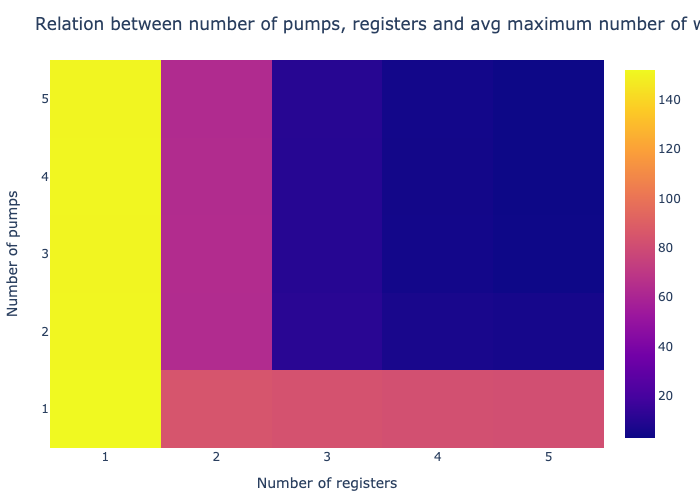

In [14]:
p = plot(heatmap(x = res.n_registers, y = res.n_pumps, z = res.avg_waiting_clients), Layout(
        xaxis_title="Number of registers",
        yaxis_title="Number of pumps",
        zaxis_title ="Avg number of waiting customers",
        title_text ="Relation between number of pumps, registers and avg maximum number of waiting clients, for arrival prob = 0.5",))

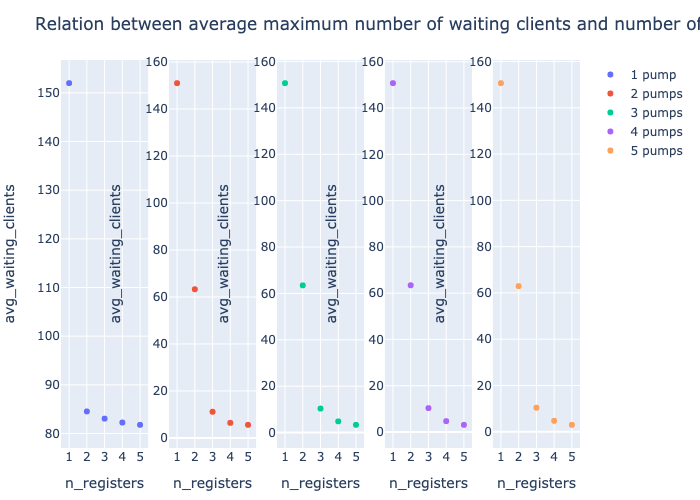

In [15]:
p1 = plot(filter(row -> row.n_pumps == 1, res), :n_registers, :avg_waiting_clients, mode = "markers", name = "1 pump")
p2 = plot(filter(row -> row.n_pumps == 2, res), :n_registers, :avg_waiting_clients, mode = "markers", name = "2 pumps")
p3 = plot(filter(row -> row.n_pumps == 3, res), :n_registers, :avg_waiting_clients, mode = "markers", name = "3 pumps")
p4 = plot(filter(row -> row.n_pumps == 4, res), :n_registers, :avg_waiting_clients, mode = "markers", name = "4 pumps")
p5 = plot(filter(row -> row.n_pumps == 5, res), :n_registers, :avg_waiting_clients, mode = "markers", name = "5 pumps")
p = [p1 p2 p3 p4 p5] 
relayout!(p, title_text = "Relation between average maximum number of waiting clients and number of cash registers per number of fuelling pumps")
p


<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

From the graphs above I can see that 2 registers are sufficient when I have 1 pump.

However, for 2 or more pumps, there is negligible change in the average waiting clients after 3 registers, thus 3 registers is the optimal for 2 pumps.  

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

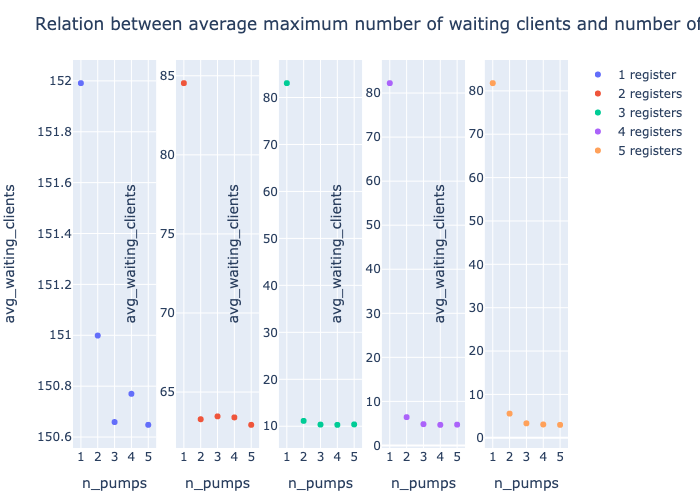

In [16]:

p6 = plot(filter(row -> row.n_registers == 1, res), :n_pumps, :avg_waiting_clients, mode = "markers", name = "1 register")
p7 = plot(filter(row -> row.n_registers == 2, res), :n_pumps, :avg_waiting_clients, mode = "markers", name = "2 registers")
p8 = plot(filter(row -> row.n_registers == 3, res), :n_pumps, :avg_waiting_clients, mode = "markers", name = "3 registers")
p9 = plot(filter(row -> row.n_registers == 4, res), :n_pumps, :avg_waiting_clients, mode = "markers", name = "4 registers")
p10 = plot(filter(row -> row.n_registers == 5, res), :n_pumps, :avg_waiting_clients, mode = "markers", name = "5 registers")
p_1 = [p6 p7 p8 p9 p10]
relayout!(p_1, title_text = "Relation between average maximum number of waiting clients and number of fuelling pumps per number of cash registers")
p_1

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

From the graph above we can see that the number of pumps does not matter when we have only 1 register, which is also intuitive, since a queue will be formed at the cash register anyway.

However, for 2 or more registers, there is negligible change in the average waiting clients after 2 pumps, thus 2 pumps is the optimal for 2 registers or more.  

The graphs above suggest, that 3 cash registers and 2 fuelling pumps are the optimal configuration for considered simulation parameters.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

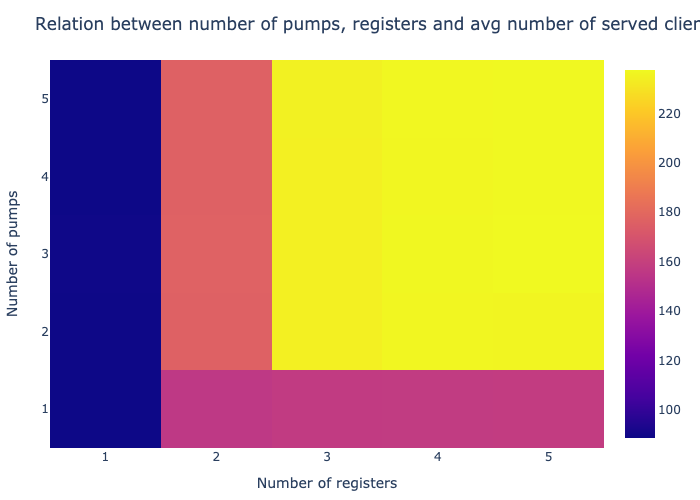

In [17]:

p = plot(heatmap(x = res.n_registers, y = res.n_pumps, z = res.avg_served_clients), Layout(
        xaxis_title="Number of registers",
        yaxis_title="Number of pumps",
        zaxis_title ="Avg number of served customers",
        title_text ="Relation between number of pumps, registers and avg number of served clients, for arrival prob = 0.5",))

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

 Another one of our main targets is to increase the avg number of served customers, which in turn leads to higher income.

 When examining the impact of the number of cash registers, it is evident that having only one register results in a significantly low value for variable z. Similarly, when considering just one pump, regardless of the quantity of registers, a similar trend is observed. Total number of served clients is significantly lower in comparison to more than 1 pump and more than 1 cash register.

When the number of cash registers is 2, a significant increase in z is observed, however it is still not high enough. Only when the minimum number of registers is 3, while the number of pumps is minimum 2, we notice that z has increased significantly and almost reached the maximum. 

For bigger numbers of pumps and registers we do not notice a significant raise in number of served clients. Therefore, we conclude, that 3 cash registers and 2 pumps are the optimal configuration. This confirms our previous finding.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

## Sensitivity Analysis

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

In this part of the study sensitivity analysis is performed. Different numbers of cash registers and fuelling pumps are considered. Different arrival probabilities, different payment and reguelling times distributions' parameters are also studied. We start with examining the impact of different arrival probabilities. Considered values are 0.1, 0.3, 0.5, 0.7 and 0.9.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

In [18]:
#Creating dataset with more arrival probabilities.
Random.seed!(0)
res_dif_arr_probs = DataFrame()
for prob in 0.1:0.2:0.9
    for p in 1:5
        for r in 1:5  
            append!(res_dif_arr_probs,run(avg_mode = true, n_pumps = p, n_registers = r, niter = 100, arrival_prob = prob))
        end
    end
end

In [19]:
#Creating bigger dataset for sensitivity analysis

# res_reg = DataFrame()
# for prob in 0.1:0.2:0.9
#     for p in 1:10
#         for r in 1:10 

#             append!(res_reg,run(avg_mode = true, n_pumps = p, n_registers = r,arrival_prob = prob ,niter = 50))
#         end
#     end
# end
# CSV.write("res_reg.csv",res_reg)
res_reg = DataFrame(CSV.File("res_reg.csv"))

,avg_served_clients,avg_waiting_clients,n_pumps,n_registers,arrival_prob,avg_refuelling_time
,Float64,Float64,Int64,Int64,Float64,Int64
1,47.6,3.6,1,1,0.1,2
2,46.4,2.22,1,2,0.1,2
3,45.96,1.78,1,3,0.1,2
4,46.3,2.04,1,4,0.1,2
5,48.7,2.12,1,5,0.1,2
6,47.8,1.82,1,6,0.1,2
7,48.78,2.02,1,7,0.1,2
8,48.78,2.02,1,8,0.1,2
9,47.62,2.02,1,9,0.1,2


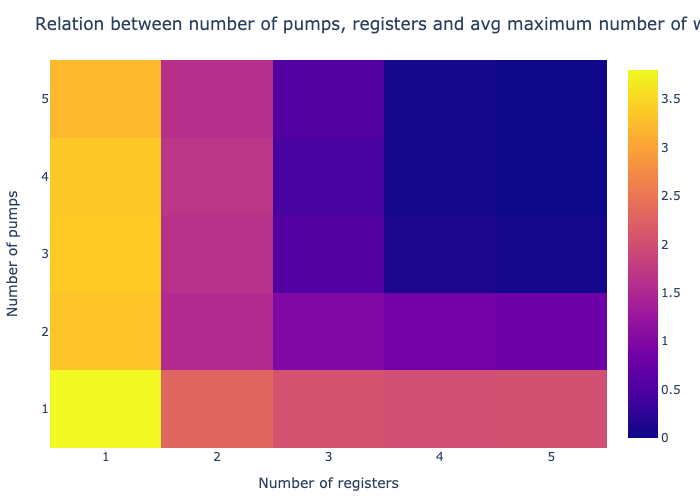

In [20]:
p1 = plot(heatmap(filter(row -> row.arrival_prob == 0.1 ,res_dif_arr_probs), x = :n_registers, y = :n_pumps, z = :avg_waiting_clients), Layout(
    xaxis_title="Number of registers",
    yaxis_title="Number of pumps",
    zaxis_title ="Avg number of waiting customers",
    title_text ="Relation between number of pumps, registers and avg maximum number of waiting clients, for arrival prob = 0.1",))

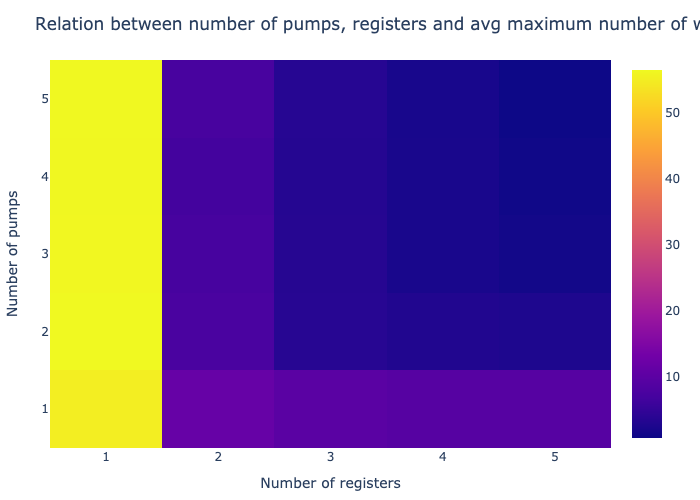

In [21]:
p2 = plot(heatmap(filter(row -> row.arrival_prob == 0.3 ,res_dif_arr_probs), x = :n_registers, y = :n_pumps, z = :avg_waiting_clients), Layout(
    xaxis_title="Number of registers",
    yaxis_title="Number of pumps",
    zaxis_title ="Avg number of waiting customers",
    title_text ="Relation between number of pumps, registers and avg maximum number of waiting clients, for arrival prob = 0.3",))

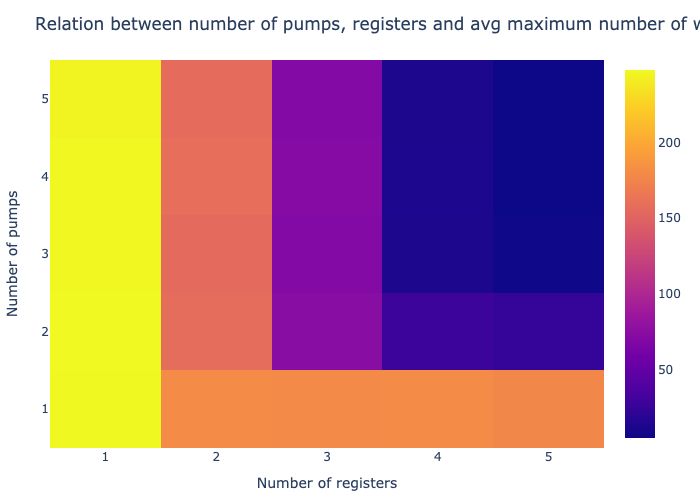

In [22]:
plot(heatmap(filter(row -> row.arrival_prob == 0.7 ,res_dif_arr_probs), x = :n_registers, y = :n_pumps, z = :avg_waiting_clients), Layout(
    xaxis_title="Number of registers",
    yaxis_title="Number of pumps",
    zaxis_title ="Avg number of waiting customers",
    title_text ="Relation between number of pumps, registers and avg maximum number of waiting clients, for arrival prob = 0.7",))

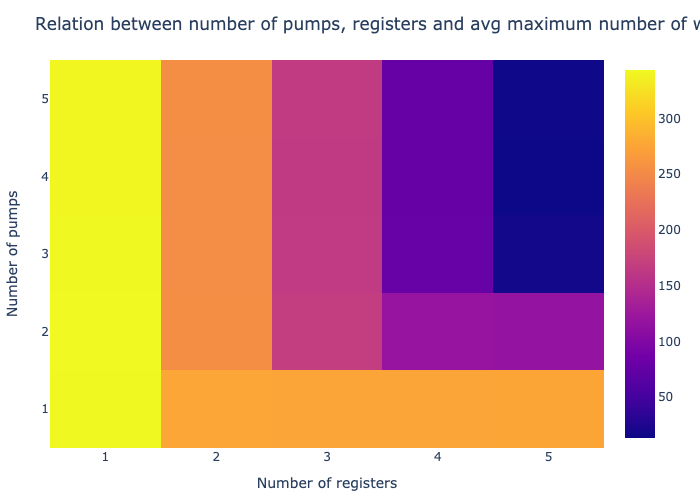

In [23]:
plot(heatmap(filter(row -> row.arrival_prob == 0.9 ,res_dif_arr_probs), x = :n_registers, y = :n_pumps, z = :avg_waiting_clients), Layout(
    xaxis_title="Number of registers",
    yaxis_title="Number of pumps",
    zaxis_title ="Avg number of waiting customers",
    title_text ="Relation between number of pumps, registers and avg maximum number of waiting clients, for arrival prob = 0.9",))

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

 For probability = 0.1, it we do not require more than 1 pump and 1 register, and that is evident from the graph. (waiting customers = 3.8)

 For probability = 0.3, we conclude similarly to that of p = 0.5 where we have 3 registers and 2 pumps. (waiting customers = 3.66)

 For probability = 0.7 , we can say that 4 registers and 3 pumps seems to be the optimal solution (waiting customers = 12.3), however with additional information and other factors, we may also consider 5 registers and 3 pumps.(z = 6.35)

 For probability = 0.9 , we can say that 5 registers and 3 pumps is the optimal solution. (waiting customers = 16.74)

 Now, we proceed to checking if more than 5 pumps and/or registers makes a signififcant impact on the average maximum number of waiting clients for 0.1, 0.3, 05, 0.7 an 0.9 arrival probabilities.
 
<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

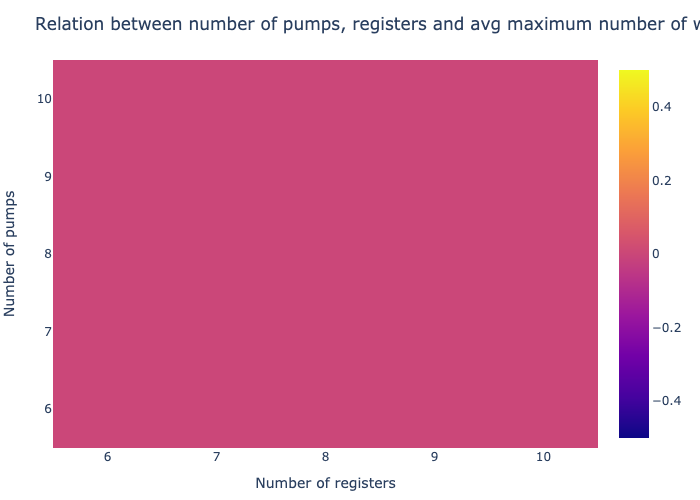

In [24]:
res_higher_n = filter(row -> row.n_pumps > 5 && row.n_pumps <11 && row.n_registers > 5 && row.n_registers < 11, res_reg)

plot(heatmap(filter(row -> row.arrival_prob == 0.1 ,res_higher_n), x = :n_registers, y = :n_pumps, z = :avg_waiting_clients), Layout(
    xaxis_title="Number of registers",
    yaxis_title="Number of pumps",
    zaxis_title ="Avg number of waiting customers",
    title_text ="Relation between number of pumps, registers and avg maximum number of waiting clients, for arrival prob = 0.1",))

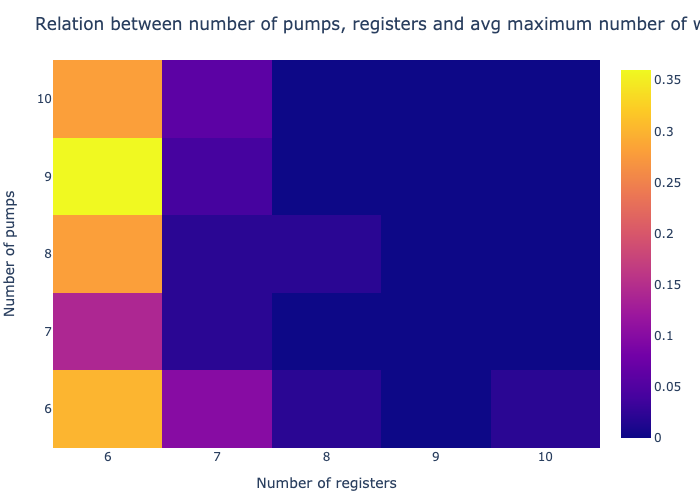

In [25]:
plot(heatmap(filter(row -> row.arrival_prob == 0.3 ,res_higher_n), x = :n_registers, y = :n_pumps, z = :avg_waiting_clients), Layout(
    xaxis_title="Number of registers",
    yaxis_title="Number of pumps",
    zaxis_title ="Avg number of waiting customers",
    title_text ="Relation between number of pumps, registers and avg maximum number of waiting clients, for arrival prob = 0.3",))

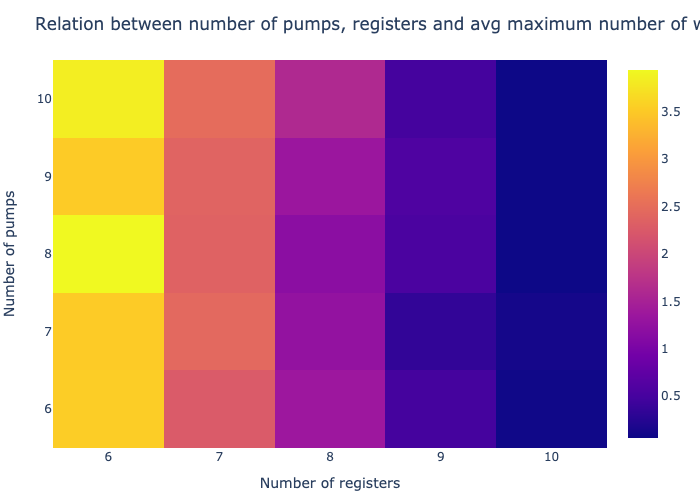

In [26]:
plot(heatmap(filter(row -> row.arrival_prob == 0.7 ,res_higher_n), x = :n_registers, y = :n_pumps, z = :avg_waiting_clients), Layout(
    xaxis_title="Number of registers",
    yaxis_title="Number of pumps",
    zaxis_title ="Avg number of waiting customers",
    title_text ="Relation between number of pumps, registers and avg maximum number of waiting clients, for arrival prob = 0.7",))

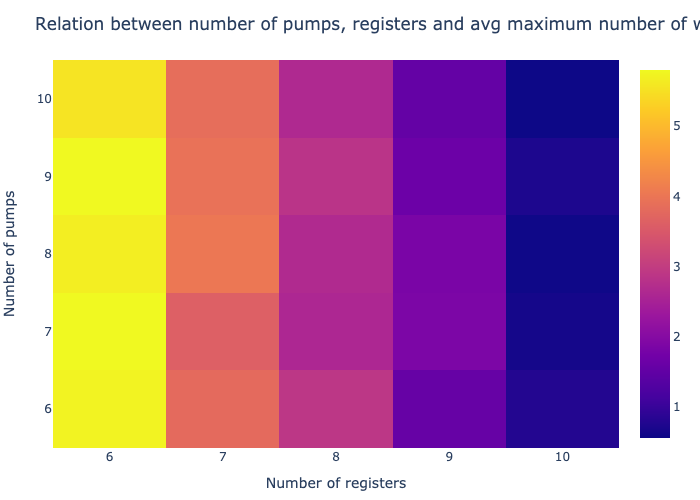

In [27]:
plot(heatmap(filter(row -> row.arrival_prob == 0.9 ,res_higher_n), x = :n_registers, y = :n_pumps, z = :avg_waiting_clients), Layout(
    xaxis_title="Number of registers",
    yaxis_title="Number of pumps",
    zaxis_title ="Avg number of waiting customers",
    title_text ="Relation between number of pumps, registers and avg maximum number of waiting clients, for arrival prob = 0.9",))

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

The following graphs show us that for bigger numbers of pumps and registers, the differences in average maximum number of  waiting customers is almost negligible. 

In graph 1, for 6-6, z = 0 whereas for 1-1, waiting customers = 3.8

In graph 2, for 6-6, z = 0.22 whereas for 3-2 , waiting customers = 3.66

In graph 3, for 6-6, z = 3.54 whereas for 4-3, waiting customers = 12.3

In graph 4, for 6-6, z = 5.72 whereas for 5-3, waiting customers = 16.74 

Next, we examine how different payment and fuelling time distributions' parameters influence the recommended numbers of cash registers and refuelling pumps. Distributions are described in the following way:

Normal(x,y) / N(x,y)

"Normal" and "N" indicates normal distribition. X is the mean valye and y is the standard deviation.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

In [28]:
#Creating new dataset containing different payment and refuelling times distribition parameters. For time saving purposes dataset was saved to CSV file after it was created.

# res_dt = DataFrame()
# for p in 1:6
#     for r in 1:6
#         for aft in 2:3:5
#             for sft in 2:3:5
#                 for apt in 2:3:5
#                     for spt in 2:3:5
#                         append!(res_dt,run(avg_mode = true, arrival_prob = 0.5 ,n_pumps = p, n_registers = r, niter = 50, avg_refuelling_time = aft, std_refuelling_time = sft, avg_payment_time = apt, std_payment_time = spt))
#                     end
#                 end
#             end
#         end
#     end
# end
# CSV.write("res_dt.csv",res_dt)
res_dt = DataFrame(CSV.File("res_dt.csv"))

,avg_served_clients,avg_waiting_clients,n_pumps,n_registers,arrival_prob,avg_refuelling_time
,Float64,Float64,Int64,Int64,Float64,Int64
1,151.82,89.42,1,1,0.5,2
2,86.76,154.84,1,1,0.5,2
3,92.28,148.46,1,1,0.5,2
4,69.06,170.66,1,1,0.5,2
5,87.12,155.4,1,1,0.5,2
6,82.6,158.98,1,1,0.5,2
7,84.4,155.68,1,1,0.5,2
8,67.54,170.34,1,1,0.5,2
9,93.6,146.46,1,1,0.5,5


In [29]:
#Defining function responsible for producing plots below.
function produce_plot(arr_prob, avg_fuelling_time, std_fuelling_time, avg_payment_time, std_payment_time)
        return plot(
                heatmap(
                    filter(
                        row -> row.arrival_prob == arr_prob && 
                            row.avg_refuelling_time == avg_fuelling_time && row.std_refuelling_time == std_fuelling_time &&
                            row.avg_payment_time == avg_payment_time && row.std_payment_time == std_payment_time ,res_dt
                            ),
                    x = :n_registers, y = :n_pumps, z = :avg_waiting_clients,
                    ),
                Layout(
                    xaxis_title="Number of registers",
                    yaxis_title="Number of pumps",
                    zaxis_title ="Avg number of waiting customers",
                    title_text ="Relation between pumps, registers and avg max waiting clients, arr prob="*string(arr_prob)*
                    "; refuelling time dist=Normal("*string(avg_fuelling_time)*", "*string(std_fuelling_time)*")"*
                    "; payment time dist=Normal("*string(avg_payment_time)*", "*string(std_payment_time)*")",
                    
                    ),
                    
            )    
end


produce_plot (generic function with 1 method)

In [30]:
pts = []
for spt in 2:3:5
    for apt in 2:3:5
        for sft in 2:3:5
            for aft in 2:3:5
                pt = produce_plot(0.5,aft,sft,apt,spt)
                length(pts) == 0 ? pts = [pt] : push!(pts, pt)
            end
        end
    end
end

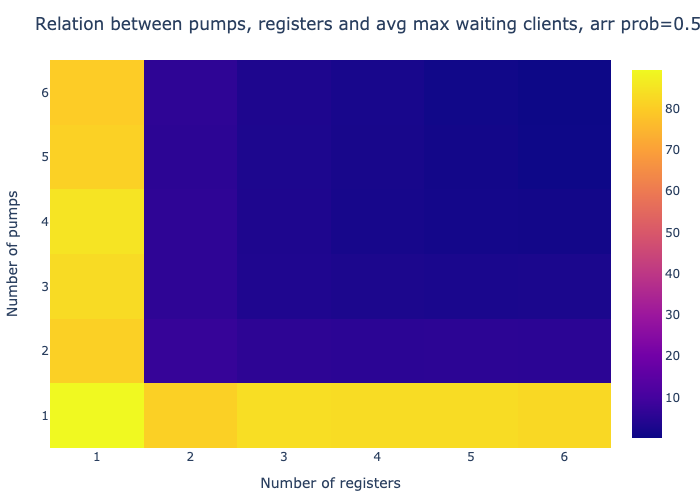

In [31]:
pts[1]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

Upon analyzing the data, it becomes evident that an optimal configuration for the system would be to have two pumps and two registers. This choice is logical and intuitive because we are dealing with two distributions that are identical (i.e., both refueling time and payment time follow the same normal distribution).

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

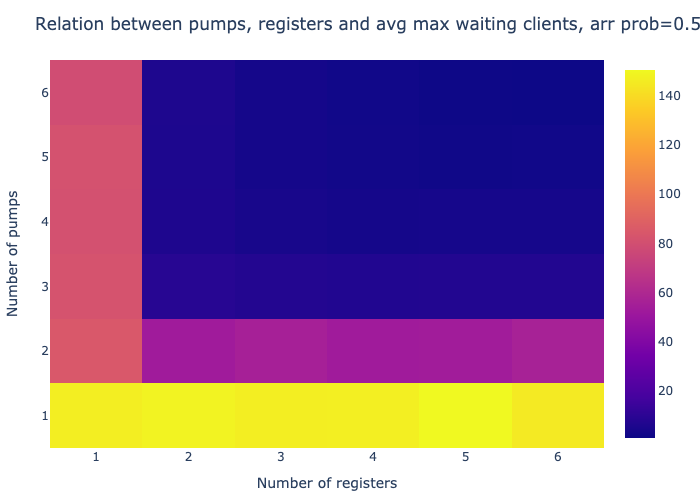

In [32]:
pts[2]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

Due to the different distributions for refueling time and payment time, the optimal configuration for this system differs from the previous case. To handle the longer refueling time (mean of 5), it is recommended to have three pumps to accommodate the increased refueling time compared to the previous scenario. The recommended number of cash registers is the same as it was in the previous scenario, as it follows the same distribution.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

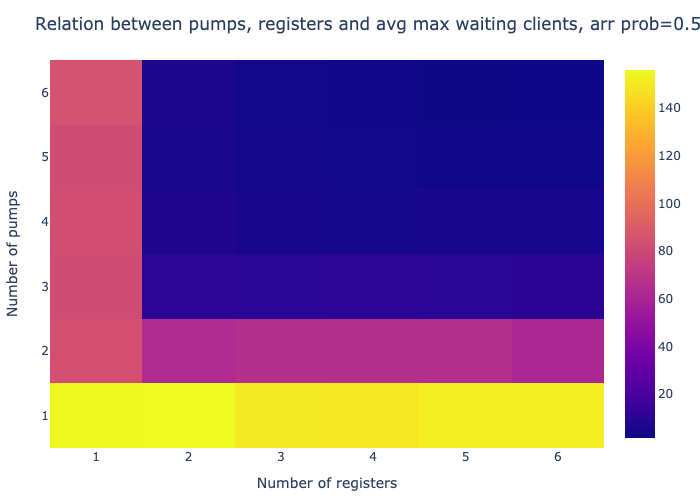

In [33]:
pts[3]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

We found that despite the different distributions, the optimal configuration remained consistent with the previous case: two cash registers and three pumps. This arrangement effectively handles customer arrivals and reduces waiting times, regardless of changes in the distribution parameters.

This finding suggests that the impact of the 2 fuelling time distributions: N(2,5) and N(5,2) is equivalent.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

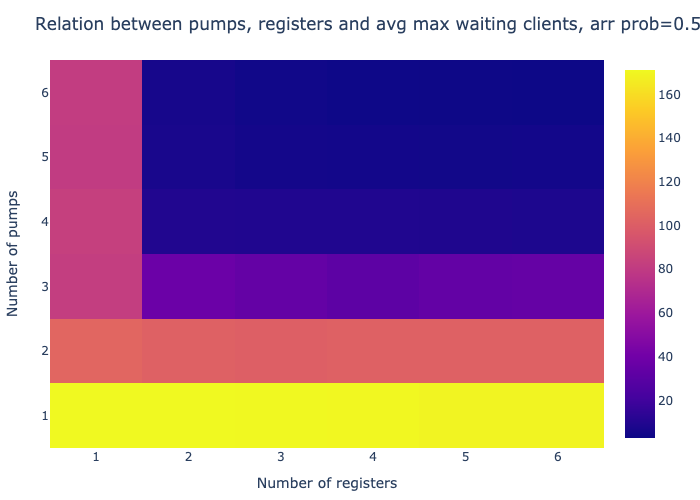

In [34]:
pts[4]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

Upon examination, it becomes apparent that if we increase both parameters of the refueling time distribution to higher values, we will require an additional refueling pump to maintain optimal performance. Hence, the recommended configuration would be to have two cash registers and four refueling pumps.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

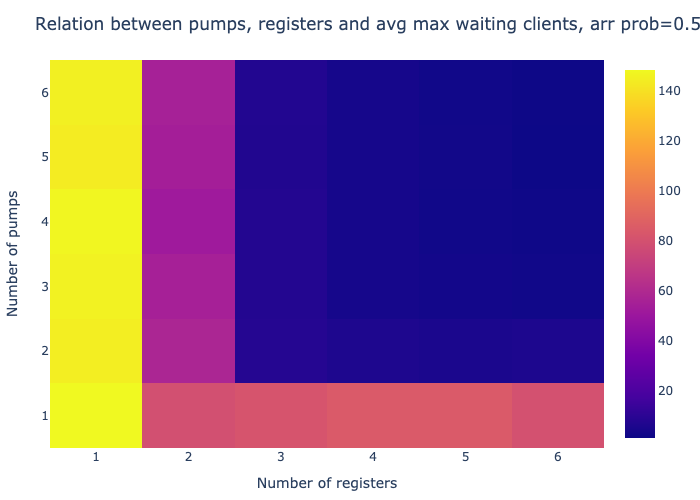

In [35]:
pts[5]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

The required configuration for optimal performance in this case is 3 pumps and 2 registers. Interestingly, this configuration remains the same as the previous cases where the distributions were N(2,5) (payment), and N(2,2) (refuelling). Despite the change in the mean and standard deviation values of the payment time distribution, the recommended number of pumps and registers remains consistent.

This suggests that the impact of the payment time distribution on the optimal configuration is equivalent between the distributions (5,2) and (2,5). The specific arrangement of mean and standard deviation in these distributions does not significantly affect the number of pumps and registers required for efficient operation. This finding is the same, as in the case of different refuelling times. 

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

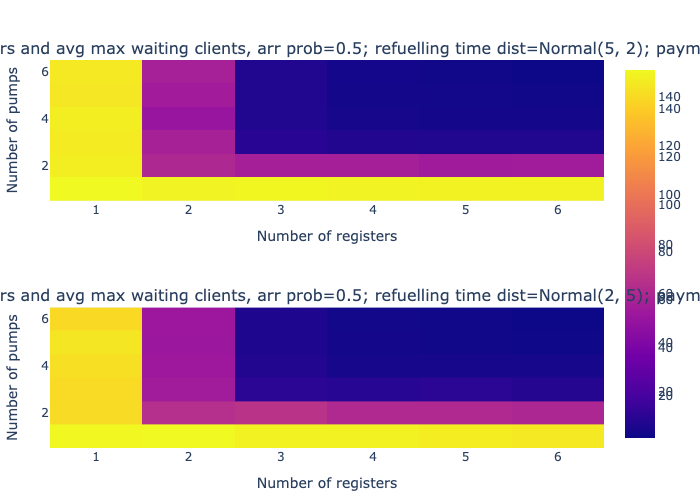

In [36]:
p = [pts[6];pts[7]]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

Upon analysis, the recommended number of pumps and registers remains consistent with previous findings. Whether we have a distribution of 5-2 (mean-standard deviation) or 2-5, the impact on the optimal configuration is the same.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

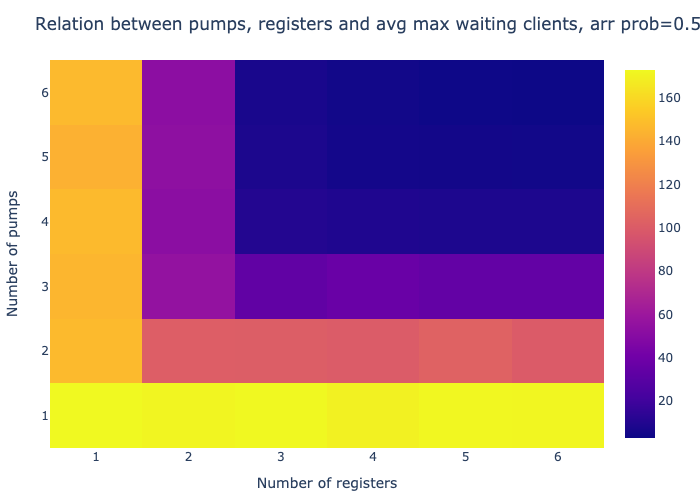

In [37]:
pts[8]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

When both parameters of the refueling time distribution are increased to higher values, an additional pump is required to maintain optimal performance. This means that the recommended configuration would be to have one more pump than in the N(2,5) scenario, resulting in a total of 4 pumps.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

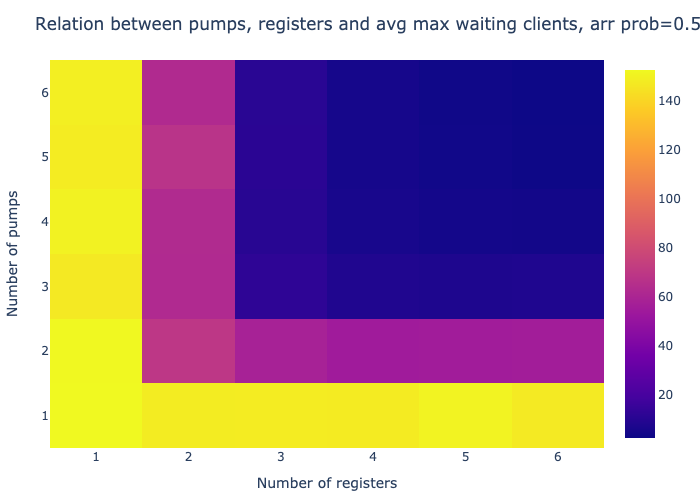

In [38]:
pts[10]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

Consistently with our previous findings, the analysis confirms that the recommended configuration for the system remains unchanged in relation to the previous N(2,5)/(N5,2) scenarios.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

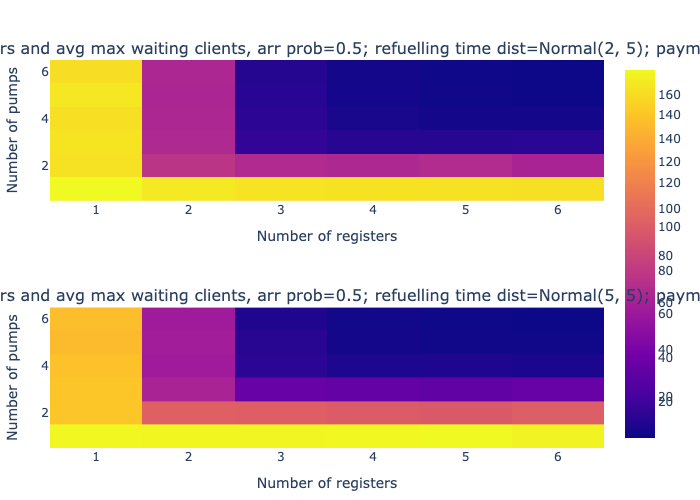

In [39]:
p = [pts[11];pts[12]]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

The analysis confirms our previous findings, providing further support to our previous conclusions. Despite the differences in the mean and standard deviation values of the refueling time and payment time distributions, the recommended configuration for the system remains consistent for both N(2,5)/N(5,2) and N(2,5)/N(5,5) scenarios.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

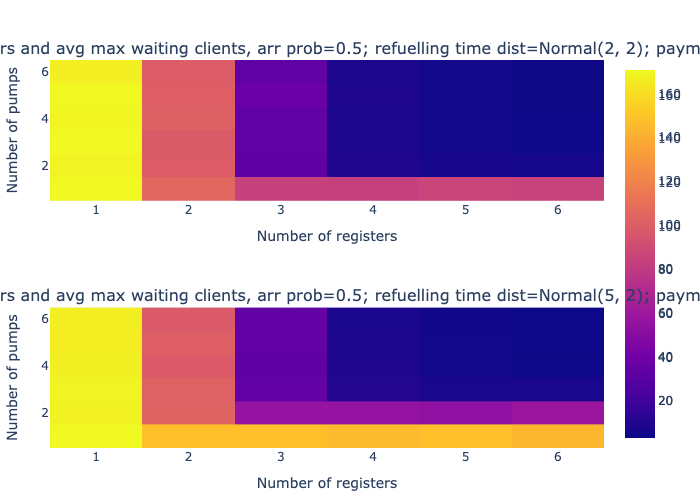

In [40]:
p = [pts[13]; pts[14]]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

The analysis reveals an outcome consistend with the previous findings. For refuelling time following N(2,2) we need 2 pumps, as in the initial scenario. When payment time distribition is N(5,5) we need 4 cash registers, which is 1 more than in the payment time of N(2,5)/N(5,2) scenarios. When refuelling time follows a N(5,2) wee need 3 pumps. 

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

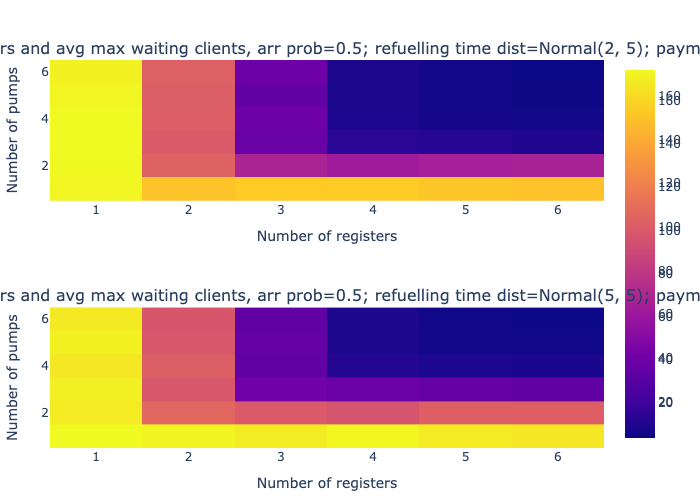

In [41]:
p = [pts[15]; pts[16]]

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

Based on the findings from various plots, it can be concluded that the impact of both refueling time and payment time on the optimal number of cash registers and refueling pumps is equivalent. Observing the plots, we notice a certain pattern: for a distribution with a mean and standard deviation of 2, two pumps/registers are required. Increasing either the mean or standard deviation by 3 corresponds to an increase of one in the number of cash registers/pumps needed.

For the distributions N(2,5), and N(5,2) three pumps/registers are recommended. Finally, for the distribution with means and standard deviations both set at 5, the optimal number increases to four pumps/registers.

In summary, the analysis reveals a clear relationship between the distribution parameters and the optimal number of cash registers and refueling pumps. Changes in the mean or standard deviation result in predictable increases in the required number of resources. These findings provide practical insights for optimizing the system's design and resource allocation to effectively manage customer arrivals and minimize waiting times.

<span style="color:Red">----------------------------------------------------------------------------------------------------------------------------------------------------------------</span>

## Conclusion 

1. The number of registers has a greater impact on the average number of waiting clients compared to the number of pumps in the initial scenario. This suggests that allocating resources to optimize the register capacity is crucial for efficient service delivery at the petrol station under initial assumptions.

2. Based on the simulations under initial assumptions, our findings indicate that the optimal solution includes 3 registers and 2 pumps. This configuration minimizes customer waiting times and maximizes overall efficiency.

3. There is no significant improvement in performance by using more than 5 pumps and/or registers. Therefore, it is unnecessary to exceed this threshold, as the differences in service quality become negligible.

4. Changes in the payment and refuelling time distribitions' parameters are equivalent. Starting in an initial optimal value of 2 pumps/registers when they follow a N(2,2) distribution, 1 more is needed per raising mean or standard deviation by 3.

5. It is important to note that additional information regarding other factors, such as costs, could have an influence on decision-making. Conducting further sensitivity analysis considering these factors would allow for a more comprehensive assessment and potentially lead to different conclusions in terms of resource allocation.

